In [1]:
import iris
import iris.plot as iplt
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/nick/python/ASoP_global/ASoP-Coherence')
from asop_coherence_global_temporal import get_asop_dict
import matplotlib.cm as mpl_cm
import numpy as np
import numpy.ma as ma
import pandas as pd
import skill_metrics as sm

In [2]:
def load_summary_metric(filename,constraint,new_long_name,new_units):
    cube = iris.load_cube(filename,constraint)
    cube.long_name = new_long_name
    cube.units = new_units
    return(cube)
def load_all_summary_metrics(asop_dict,wet_season_threshold='1d24'):
    constraints_longnames_units = [
        ('Temporal intermittency on-off metric based on 4 divisions (mean of all months in wet season)','Temporal coherence metric, 4 divs, all wet season, 3hr - '+asop_dict['name'],'1'),
        ('Probability of upper division followed by upper division (mean of all months in wet season)','p(on|on), 4 divs, all wet season, 3hr '+asop_dict['name'],'1'),
        ('Probability of upper division followed by lower division (mean of all months in wet season)','p(on|off), 4 divs, all wet season, 3hr '+asop_dict['name'],'1'),
        ('Probability of lower division followed by upper division (mean of all months in wet season)','p(off|on), 4 divs, all wet season, 3hr '+asop_dict['name'],'1'),
        ('Probability of lower division followed by lower division (mean of all months in wet season)','p(off|off), 4 divs, all wet season, 3hr '+asop_dict['name'],'1')
    ]
    out_cubelist = []
    summary_file = asop_dict['desc']+'_asop_temporal_summary_wetseason'+wet_season_threshold+'.nc'
    for constraint,long_name,units in constraints_longnames_units:
        cube = load_summary_metric(str(asop_dict['dir']/summary_file),constraint,long_name,units)
        out_cubelist.append(cube)
    return(out_cubelist)

In [3]:
def find_autocorr_threshold(cube,lag_length,threshold=0.5,long_name=None,units=None):
    import numpy as np
    #max_autocorr = cube.collapsed('lag',iris.analysis.MEAN).copy()
    lon = cube.coord('longitude')
    lat = cube.coord('latitude')
    nlon = len(lon.points)
    nlat = len(lat.points)
    nlag = len(cube.coord('lag').points)
#    max_autocorr = iris.cube.Cube(np.ma.empty((nlat,nlon)),dim_coords_and_dims=[(lat,0),(lon,1)])
    max_autocorr = np.zeros((nlat,nlon))
    for y in range(nlat):
        for x in range(nlon):
            below_threshold = np.where(cube.data[:,y,x] <= threshold)
            if np.sum(below_threshold) >= 1:
                max_autocorr[y,x] = np.amin(below_threshold)*lag_length+0.5
            else:
                max_autocorr[y,x] = nlag*lag_length+0.5
    max_autocorr_cube = iris.cube.Cube(data=max_autocorr,dim_coords_and_dims=[(lat,0),(lon,1)],long_name=long_name,units=units,var_name='autocorr_threshold'+str(threshold))
    return(max_autocorr_cube) 

In [4]:
def compute_summary_stats(model_cube,obs_cube,region,region_type,region_name,diag_name,model_dict,mask=None):
    import pandas as pd
    # Average space-time summary metrics over a given region.
    # Mask for land-only if requested.
    import iris.analysis.stats as istats
    grid_constraint = iris.Constraint(latitude=lambda cell: region[0] <= cell <= region[1],
                                      longitude=lambda cell: region[2] <= cell <= region[3])
    model_region = model_cube.extract(grid_constraint)
    obs_region = obs_cube.extract(grid_constraint)
    if region_type == 'land' or region_type == 'ocean':
        if mask is None:
            raise Exception('Computing summary stats over '+region_type+' requires a mask, but mask is None.')
        mask_region = mask.extract(grid_constraint)
        mask_region.coord('longitude').guess_bounds()
        mask_region.coord('latitude').guess_bounds()
        mask_region = mask_region.regrid(model_region,iris.analysis.AreaWeighted())
        if region_type == 'land':
            model_region = model_region.copy(data=np.ma.array(model_region.data,mask=np.where(mask_region.data > 0.5,False,True)))
            obs_region = obs_region.copy(data=np.ma.array(obs_region.data,mask=np.where(mask_region.data > 0.5,False,True)))
        if region_type == 'ocean':
            model_region = model_region.copy(data=np.ma.array(model_region.data,mask=np.where(mask_region.data < 0.5,False,True)))
            obs_region = obs_region.copy(data=np.ma.array(obs_region.data,mask=np.where(mask_region.data < 0.5,False,True)))
    weights = iris.analysis.cartography.area_weights(model_region)
    model_avg = model_region.collapsed(['longitude','latitude'],iris.analysis.MEAN,weights=weights)
    obs_avg = obs_region.collapsed(['longitude','latitude'],iris.analysis.MEAN,weights=weights)
    
    diff = model_region-obs_region
    bias = diff.collapsed(('longitude','latitude'),iris.analysis.MEAN,weights=weights)
    rmse = diff.collapsed(('longitude','latitude'),iris.analysis.RMS,weights=weights)
    std = model_region.collapsed(('longitude','latitude'),iris.analysis.STD_DEV)
    pcorr = istats.pearsonr(model_region,obs_region) #,corr_coords=('latitude','longitude'))
    #ts = sm.taylor_statistics(model_region.data.flatten(),obs_region.data.flatten(),'data')
    ts = [std.data,rmse.data,pcorr.data,bias.data]
    print(ts)
    return(ts)

In [5]:
gpm_dict = get_asop_dict('GPM_IMERG')
gpm_temporal_summary,gpm_ponon,gpm_ponoff,gpm_poffon,gpm_poffoff = load_all_summary_metrics(gpm_dict)
gpm_autocorr_filename = str(gpm_dict['dir'])+'/'+gpm_dict['desc']+'_asop_temporal_autocorr_wetseason1d24.nc'
gpm_autocorr = load_summary_metric(gpm_autocorr_filename,'autocorr_wetseason_precip_mean',None,'Hours')

In [17]:
regions = [
    ([-30,30,0,360],'trop'),
    ([-60,-30,0,360],'sh'),
    ([30,60,0,360],'nh'),
    ([-60,60,0,360],'glob')
]
nregions = len(regions)
mask_file='/media/nick/lacie_tb3/datasets/land_sea_mask/landfrac_n216e_hadgem3-10.3.nc'
mask = iris.load_cube(mask_file,'land_area_fraction')
metrics = pd.DataFrame()

In [21]:
autocorr_threshold=0.5
gpm_autocorr_threshold = find_autocorr_threshold(gpm_autocorr,3,threshold=autocorr_threshold,long_name='Temporal autocorr metric, >'+str(autocorr_threshold)+', all wet season, 3hr - GPM',units='Hours')
models = ['GPM_IMERG','ACCESS','AWI','BCC','FGOALS','GISS','MIROC','MPI-ESM1','SAM0-UNICON'] # Specify GPM first to get Taylor statistics
nmodels = len(models)
#model_names=['OBS']

--> trop
-->--> both
-->-->--> GPM_IMERG
[array(17.01324291), array(0.), array(1.), array(0.)]
-->-->--> ACCESS
[array(15.68323134), array(12.72221523), array(0.7087238), array(2.28793427)]
-->-->--> AWI
[array(17.95395894), array(13.31585672), array(0.71336084), array(0.99108921)]
-->-->--> BCC
[array(15.39218264), array(12.9926685), array(0.67988555), array(-0.13893464)]
-->-->--> FGOALS
[array(17.48472402), array(12.41910535), array(0.73870089), array(1.1333626)]
-->-->--> GISS
[array(13.26747295), array(14.92044767), array(0.55367149), array(2.98506156)]
-->-->--> MIROC
[array(14.90057194), array(11.6745176), array(0.73570752), array(0.53455097)]
-->-->--> MPI-ESM1
[array(17.43050103), array(13.5630813), array(0.68843533), array(0.18946692)]
-->-->--> SAM0-UNICON
[array(14.92159393), array(13.32876436), array(0.66656753), array(2.19658986)]
-->--> land
-->-->--> GPM_IMERG
[array(18.6824867), array(0.), array(1.), array(0.)]
-->-->--> ACCESS
[array(19.71474859), array(12.82470656), 

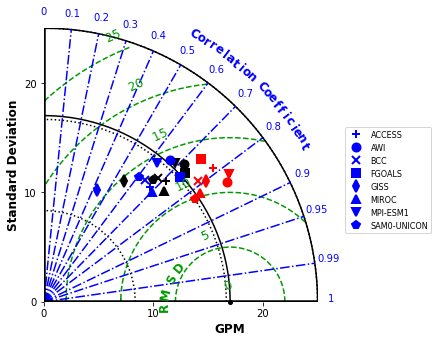

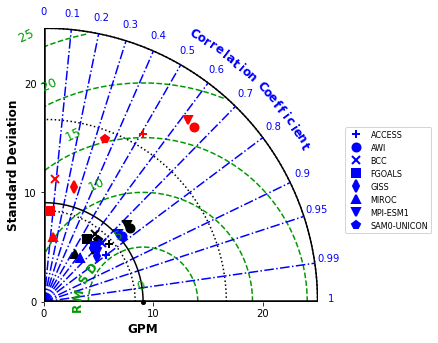

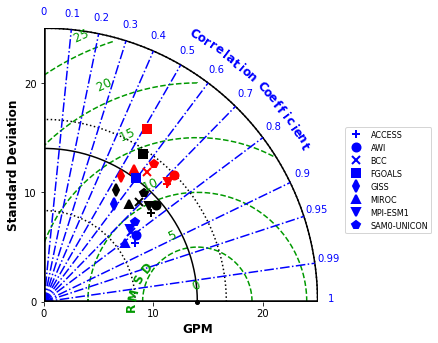

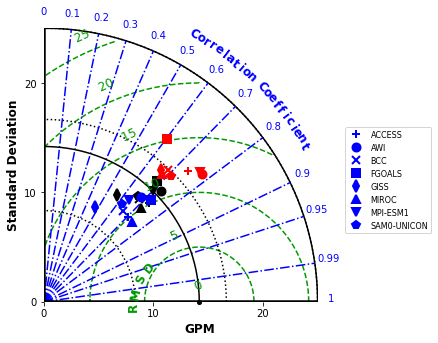

In [22]:
for region,region_name in regions:
    print('--> '+region_name)
    plt.figure(figsize=(8, 6))
    region_types=[
        ('both','off','k'),
        ('land','on','r'),
        ('ocean','on','b')
    ]
    for region_type,overlay,color in region_types:
        print('-->--> '+region_type)
        sdev = np.empty(nmodels) 
        rmsd = np.empty(nmodels)
        corr = np.empty(nmodels)
        bias = np.empty(nmodels)
        for m,model in enumerate(models):
            print('-->-->--> '+model)
            model_dict = get_asop_dict(model)
            model_temporal_summary,model_ponon,model_ponoff,model_poffon,model_poffoff = load_all_summary_metrics(model_dict)
            model_autocorr_filename = str(model_dict['dir'])+'/'+model_dict['desc']+'_asop_temporal_autocorr_wetseason1d24.nc'
            model_autocorr = load_summary_metric(model_autocorr_filename,'autocorr_wetseason_precip_mean',None,'Hours')
            model_autocorr_threshold = find_autocorr_threshold(model_autocorr,3,threshold=autocorr_threshold,long_name='Temporal autocorr metric, >'+str(autocorr_threshold)+', all wet season, 3hr - '+model_dict['name'],units='Hours')
            ts = compute_summary_stats(model_autocorr_threshold,gpm_autocorr_threshold,region,region_type,region_name,'autocorr_threshold'+str(autocorr_threshold),model_dict,mask=mask)
            sdev[m] = np.array(ts[0])
            rmsd[m] = np.array(ts[1])
            corr[m] = np.array(ts[2])
            bias[m] = np.array(ts[3])        
        sm.taylor_diagram(sdev,rmsd,corr,markerLabel=models,markerLegend='on',markerLabelColor='k',markerColor=color, styleOBS = '-', colOBS = color, markerobs = 'o',markerSize = 8,tickRMSangle = 115, showlabelsRMS = 'on',titleRMS = 'on', titleOBS = 'GPM', checkstats = 'on',overlay=overlay,axismax=25,tickrms=[0,5,10,15,20,25]) 
        #,cmapzdata=bias,titleColorBar='Bias (hours)',markerDisplayed='colorBar')
    plt.savefig('plots/asop_coherence_global_temporal_taylor_3hr_autocorr'+str(autocorr_threshold)+'_'+region_name+'.png',dpi=200)